In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

In [ ]:
# Load dữ liệu
df = pd.read_csv('../data/processed/featured_data.csv')
print(f"Đã load dữ liệu: {df.shape[0]:,} dòng, {df.shape[1]} cột")

# Load mô hình
best_model = joblib.load('../models/best_model.pkl')
scaler = joblib.load('../models/scaler.pkl')
print("Đã load mô hình và scaler")

# Load features list
with open('../models/features_list.json', 'r') as f:
    features_list = json.load(f)
print(f"Đã load danh sách {len(features_list)} features")

# Load model info
with open('../models/model_info.json', 'r') as f:
    model_info = json.load(f)
print(f"Đã load thông tin mô hình")

print(f"\nThông tin mô hình:")
for key, value in model_info.items():
    if isinstance(value, float):
        print(f"   - {key}: {value:.4f}")
    else:
        print(f"   - {key}: {value}")

# Chuẩn bị dữ liệu
from sklearn.model_selection import train_test_split

X = df[features_list]
y = df['salary_avg_vnd']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTrain: {len(X_train):,} | Test: {len(X_test):,}")

Đã load dữ liệu: 75,897 dòng, 52 cột
Đã load mô hình và scaler
Đã load danh sách 38 features
Đã load thông tin mô hình

Thông tin mô hình:
   - model_type: RandomForestRegressor
   - best_params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
   - test_mae: 0.0211
   - test_rmse: 0.2348
   - test_r2: 0.9983
   - n_features: 38
   - n_train_samples: 60717
   - n_test_samples: 15180

Train: 60,717 | Test: 15,180


# ĐÁNH GIÁ CHI TIẾT TRÊN TEST SET

In [4]:
# Dự đoán
y_pred = best_model.predict(X_test)

# Tính các metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"\nMETRICS TRÊN TEST SET:")
print(f"   • MAE (Mean Absolute Error):         {mae:,.0f} VND")
print(f"   • RMSE (Root Mean Squared Error):    {rmse:,.0f} VND")
print(f"   • R² Score:                          {r2:.4f}")
print(f"   • MAPE (Mean Abs Percentage Error):  {mape:.2f}%")


METRICS TRÊN TEST SET:
   • MAE (Mean Absolute Error):         0 VND
   • RMSE (Root Mean Squared Error):    0 VND
   • R² Score:                          0.9983
   • MAPE (Mean Abs Percentage Error):  0.20%


In [6]:
# Phân tích theo khoảng lương
print(f"\nPhân tích MAE theo khoảng lương:")

salary_ranges = [
    (0, 10_000_000, 'Dưới 10M'),
    (10_000_000, 20_000_000, '10M-20M'),
    (20_000_000, 30_000_000, '20M-30M'),
    (30_000_000, 50_000_000, '30M-50M'),
    (50_000_000, float('inf'), 'Trên 50M')
]

range_analysis = []
for min_sal, max_sal, label in salary_ranges:
    mask = (y_test >= min_sal) & (y_test < max_sal)
    if mask.sum() > 0:
        range_mae = mean_absolute_error(y_test[mask], y_pred[mask])
        range_count = mask.sum()
        range_analysis.append({
            'Khoảng lương': label,
            'Số lượng': range_count,
            'MAE': range_mae,
            'MAE %': (range_mae / y_test[mask].mean()) * 100
        })

range_df = pd.DataFrame(range_analysis)
print(range_df.to_string(index=False))


Phân tích MAE theo khoảng lương:
Khoảng lương  Số lượng      MAE    MAE %
    Dưới 10M     15180 0.021071 0.147113


# CROSS-VALIDATION ANALYSIS

In [7]:
print("\nK-Fold Cross-Validation (k=5):")

cv_scores_mae = cross_val_score(
    best_model, X_train, y_train,
    cv=5, scoring='neg_mean_absolute_error', n_jobs=-1
)
cv_scores_mae = -cv_scores_mae

cv_scores_r2 = cross_val_score(
    best_model, X_train, y_train,
    cv=5, scoring='r2', n_jobs=-1
)

print(f"   MAE scores: {[f'{s:,.0f}' for s in cv_scores_mae]}")
print(f"   Mean MAE: {cv_scores_mae.mean():,.0f} (±{cv_scores_mae.std():,.0f})")
print(f"\n   R² scores: {[f'{s:.4f}' for s in cv_scores_r2]}")
print(f"   Mean R²: {cv_scores_r2.mean():.4f} (±{cv_scores_r2.std():.4f})")


K-Fold Cross-Validation (k=5):
   MAE scores: ['0', '0', '0', '0', '0']
   Mean MAE: 0 (±0)

   R² scores: ['0.9973', '0.9980', '0.9978', '0.9974', '0.9977']
   Mean R²: 0.9976 (±0.0002)


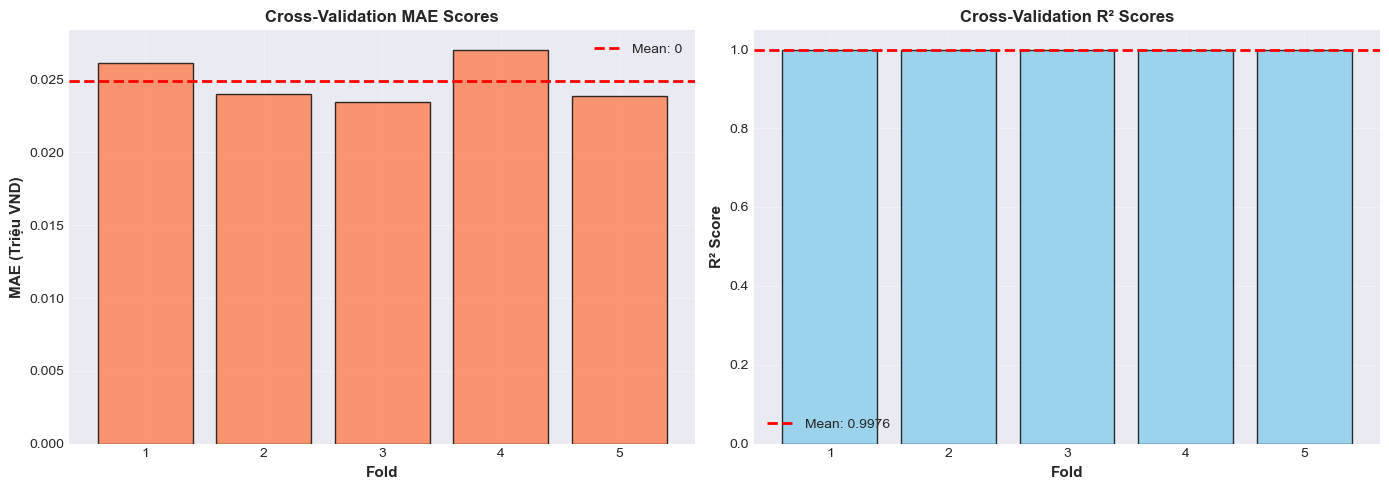


Đã lưu biểu đồ cross-validation!


In [ ]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAE
axes[0].bar(range(1, 6), cv_scores_mae, color='coral', edgecolor='black', alpha=0.8)
axes[0].axhline(y=cv_scores_mae.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cv_scores_mae.mean():,.0f}')
axes[0].set_xlabel('Fold', fontsize=11, fontweight='bold')
axes[0].set_ylabel('MAE (Triệu VND)', fontsize=11, fontweight='bold')
axes[0].set_title('Cross-Validation MAE Scores', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# R²
axes[1].bar(range(1, 6), cv_scores_r2, color='skyblue', edgecolor='black', alpha=0.8)
axes[1].axhline(y=cv_scores_r2.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cv_scores_r2.mean():.4f}')
axes[1].set_xlabel('Fold', fontsize=11, fontweight='bold')
axes[1].set_ylabel('R² Score', fontsize=11, fontweight='bold')
axes[1].set_title('Cross-Validation R² Scores', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./figures/06_cross_validation.png', dpi=300, bbox_inches='tight')
plt.show()
print("\nĐã lưu biểu đồ cross-validation!")

# LEARNING CURVE

Đang tính toán learning curves...


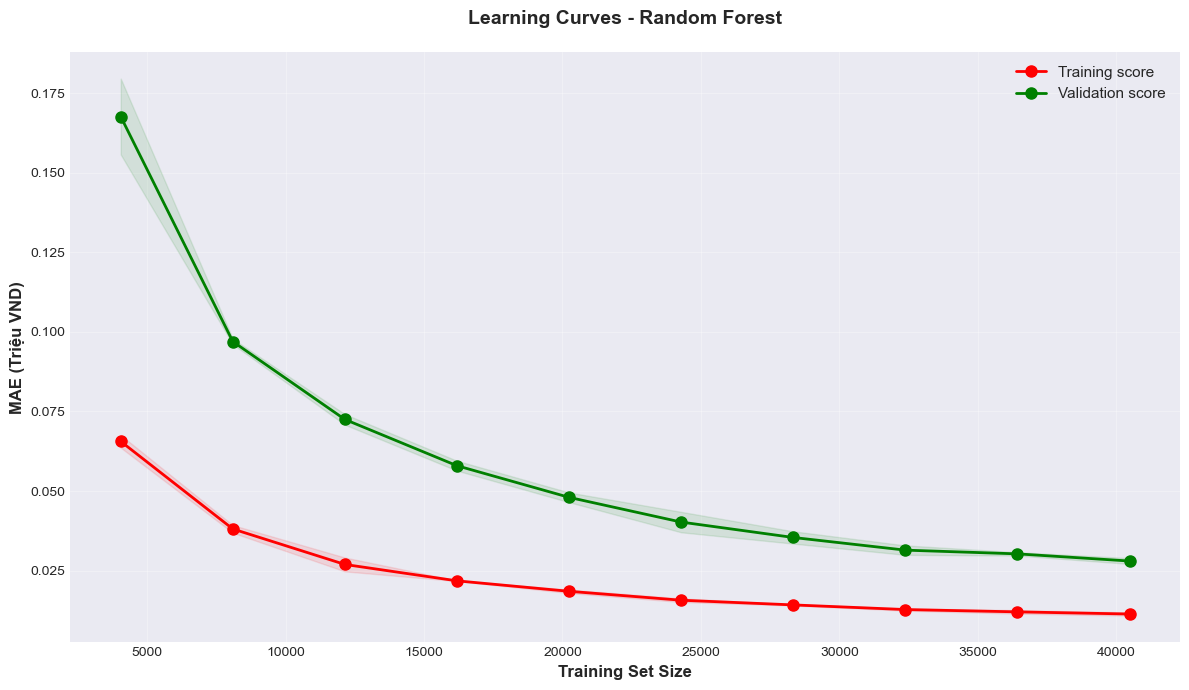

Đã lưu learning curve!


In [ ]:
print("Đang tính toán learning curves...")

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = -val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

plt.figure(figsize=(12, 7))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score', linewidth=2, markersize=8)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')

plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation score', linewidth=2, markersize=8)
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color='g')

plt.xlabel('Training Set Size', fontsize=12, fontweight='bold')
plt.ylabel('MAE (Triệu VND)', fontsize=12, fontweight='bold')
plt.title('Learning Curves - Random Forest', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='best', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('./figures/06_learning_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print("Đã lưu learning curve!")

# PHÂN TÍCH SAI SỐ CHI TIẾT

In [11]:
# Tính errors
errors = y_test - y_pred
abs_errors = np.abs(errors)
pct_errors = (abs_errors / y_test) * 100

print(f"\nThống kê lỗi:")
print(f"   • Mean Error:           {errors.mean():,.0f}tr VND")
print(f"   • Median Error:         {np.median(errors):,.0f}tr VND")
print(f"   • Mean Absolute Error:  {abs_errors.mean():,.0f}tr VND")
print(f"   • Max Error:            {abs_errors.max():,.0f}tr VND")
print(f"   • Min Error:            {abs_errors.min():,.0f}tr VND")

print(f"\nPhân tích phần trăm lỗi:")
print(f"   • Samples with <10% error:  {(pct_errors < 10).sum():,} ({(pct_errors < 10).mean()*100:.1f}%)")
print(f"   • Samples with <20% error:  {(pct_errors < 20).sum():,} ({(pct_errors < 20).mean()*100:.1f}%)")
print(f"   • Samples with <30% error:  {(pct_errors < 30).sum():,} ({(pct_errors < 30).mean()*100:.1f}%)")
print(f"   • Samples with >=30% error: {(pct_errors >= 30).sum():,} ({(pct_errors >= 30).mean()*100:.1f}%)")

# Tìm worst predictions
print(f"\nTop 10 dự đoán tệ nhất:")
worst_idx = abs_errors.nlargest(10).index
worst_predictions = pd.DataFrame({
    'Actual': y_test.loc[worst_idx],
    'Predicted': y_pred[y_test.index.get_indexer(worst_idx)],
    'Error': abs_errors.loc[worst_idx],
    'Error %': pct_errors.loc[worst_idx]
})
print(worst_predictions.to_string())


Thống kê lỗi:
   • Mean Error:           0tr VND
   • Median Error:         0tr VND
   • Mean Absolute Error:  0tr VND
   • Max Error:            9tr VND
   • Min Error:            0tr VND

Phân tích phần trăm lỗi:
   • Samples with <10% error:  15,117 (99.6%)
   • Samples with <20% error:  15,143 (99.8%)
   • Samples with <30% error:  15,162 (99.9%)
   • Samples with >=30% error: 18 (0.1%)

Top 10 dự đoán tệ nhất:
       Actual  Predicted     Error     Error %
8256    30.00  21.301351  8.698649   28.995497
32139   22.25  14.735750  7.514250   33.771910
68166    5.00  12.372307  7.372307  147.446130
11673   10.00  16.398455  6.398455   63.984545
6279    23.00  17.069000  5.931000   25.786957
33356   25.00  19.490000  5.510000   22.040000
1298     8.50  13.958389  5.458389   64.216344
29993   25.00  19.640000  5.360000   21.440000
37612   33.00  27.840000  5.160000   15.636364
7266    32.00  26.892500  5.107500   15.960938


# PHÂN TÍCH THEO NHÓM

In [12]:
# Theo cấp bậc
print("\nMAE theo cấp bậc:")
position_analysis = []
for position in df['position_level'].unique():
    mask = df.loc[X_test.index, 'position_level'] == position
    if mask.sum() > 0:
        pos_mae = mean_absolute_error(y_test[mask], y_pred[mask])
        pos_count = mask.sum()
        position_analysis.append({
            'Position': position,
            'Count': pos_count,
            'MAE': pos_mae
        })

pos_df = pd.DataFrame(position_analysis).sort_values('MAE')
print(pos_df.to_string(index=False))


MAE theo cấp bậc:
     Position  Count      MAE
Chưa cập nhật      1 0.000000
 Phó giám đốc      5 0.000000
   Chuyên gia     19 0.001053
 Trưởng phòng    556 0.009172
    Nhân viên  13048 0.016167
Cộng tác viên     42 0.027619
     Giám đốc     40 0.055125
      Quản lý    665 0.062540
Thực tập sinh    316 0.063244
  Trưởng nhóm    488 0.079633


In [14]:
# Theo thành phố (top 10)
print("\nMAE theo thành phố (Top 10):")
top_cities = df['city'].value_counts().head(10).index
city_analysis = []
for city in top_cities:
    mask = df.loc[X_test.index, 'city'] == city
    if mask.sum() > 0:
        city_mae = mean_absolute_error(y_test[mask], y_pred[mask])
        city_count = mask.sum()
        city_analysis.append({
            'City': city,
            'Count': city_count,
            'MAE': city_mae
        })

city_df = pd.DataFrame(city_analysis).sort_values('MAE')
print(city_df.to_string(index=False))


MAE theo thành phố (Top 10):
       City  Count      MAE
   Tây Ninh    164 0.008330
   Đồng Nai    446 0.011781
     Hà Nội   4932 0.014754
  Hải Phòng    266 0.016382
    Long An    316 0.017052
 Bình Dương    757 0.019449
Hồ Chí Minh   4740 0.033846
    Đà Nẵng    232 0.036823
   Hưng Yên    205 0.047008
   Bắc Ninh    185 0.057395


# CLUSTERING ANALYSIS - PHÂN CỤM DỮ LIỆU


K-Means Clustering:

Số lượng mẫu trong mỗi cluster:
   Cluster 0: 39,628 (52.2%)
   Cluster 1: 7,029 (9.3%)
   Cluster 2: 21,010 (27.7%)
   Cluster 3: 8,230 (10.8%)

Đặc điểm trung bình của mỗi cluster:
         salary_avg_vnd  experience_years  skills_count  \
cluster                                                   
0             10.922294          0.536187      2.508479   
1             14.547037          1.999431      9.078816   
2             18.457013          2.128510      2.493622   
3             20.033566          2.727339      3.030377   

         position_level_encoded  
cluster                          
0                      2.961568  
1                      3.111965  
2                      2.999667  
3                      6.258809  


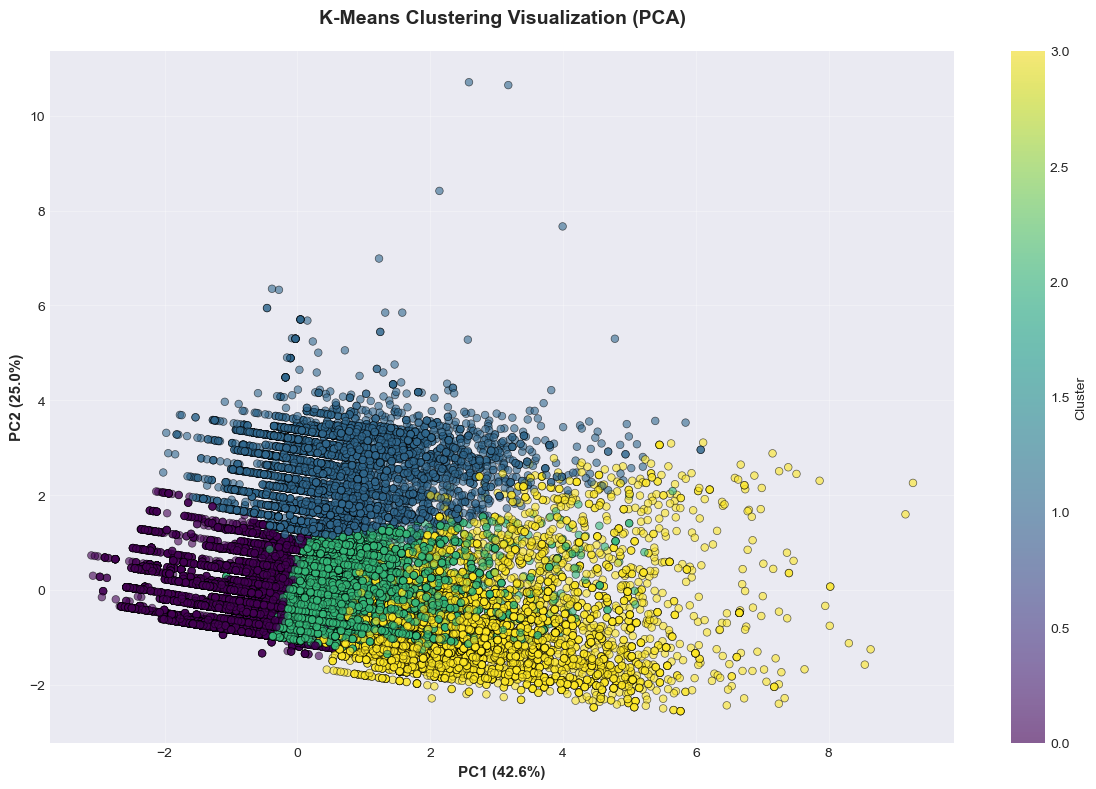


Đã lưu biểu đồ clustering!


In [ ]:
print("\nK-Means Clustering:")

# Chọn features cho clustering
cluster_features = ['salary_avg_vnd', 'experience_years', 'skills_count', 'position_level_encoded']
X_cluster = df[cluster_features].dropna()

# Chuẩn hóa
from sklearn.preprocessing import StandardScaler
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

# K-Means với k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_cluster_scaled)

# Phân tích clusters
print(f"\nSố lượng mẫu trong mỗi cluster:")
unique, counts = np.unique(clusters, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"   Cluster {cluster}: {count:,} ({count/len(clusters)*100:.1f}%)")

# Đặc điểm từng cluster
print(f"\nĐặc điểm trung bình của mỗi cluster:")
X_cluster['cluster'] = clusters
cluster_summary = X_cluster.groupby('cluster')[cluster_features].mean()
print(cluster_summary)

# Visualization - PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', 
                     alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11, fontweight='bold')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11, fontweight='bold')
plt.title('K-Means Clustering Visualization (PCA)', fontsize=14, fontweight='bold', pad=20)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('./figures/06_clustering_kmeans.png', dpi=300, bbox_inches='tight')
plt.show()
print("\nĐã lưu biểu đồ clustering!")

In [16]:
# Gán cluster labels cho tập gốc
df_clustered = df.copy()
df_clustered['cluster'] = -1
df_clustered.loc[X_cluster.index, 'cluster'] = clusters

# BUSINESS INSIGHTS

In [18]:
insights = {
    "Hiệu suất mô hình": [
        f"Mô hình có khả năng dự đoán với MAE = {mae:,.0f}tr VND (~{mape:.1f}% lương)",
        f"R² = {r2:.3f} nghĩa là mô hình giải thích được {r2*100:.1f}% phương sai của lương",
        f"Cross-validation ổn định với std = {cv_scores_mae.std():,.0f}tr VND"
    ],
    
    "Độ chính xác theo nhóm": [
        f"Dự đoán tốt nhất cho cấp bậc: {pos_df.iloc[0]['Position']} (MAE = {pos_df.iloc[0]['MAE']:,.0f})",
        f"Dự đoán kém nhất cho cấp bậc: {pos_df.iloc[-1]['Position']} (MAE = {pos_df.iloc[-1]['MAE']:,.0f})",
        f"{(pct_errors < 20).mean()*100:.1f}% dự đoán có sai số dưới 20%"
    ],
    
    "Features quan trọng": [
        f"Top 3 features: {', '.join(pd.DataFrame({'f': features_list, 'i': best_model.feature_importances_}).nlargest(3, 'i')['f'].tolist())}",
        f"Kinh nghiệm và cấp bậc là yếu tố ảnh hưởng mạnh nhất đến lương",
        f"Địa điểm và kỹ năng cũng có tác động đáng kể"
    ],
    
    "Phân cụm công việc": [
        f"Có thể chia thị trường thành 4 nhóm công việc chính",
        f"Mỗi cluster có đặc điểm riêng về lương, kinh nghiệm và yêu cầu",
        f"Hữu ích cho định vị và chiến lược tuyển dụng"
    ]
}

print("\nKEY INSIGHTS:")
for category, points in insights.items():
    print(f"\n{category}:")
    for point in points:
        print(f"   • {point}")


KEY INSIGHTS:

Hiệu suất mô hình:
   • Mô hình có khả năng dự đoán với MAE = 0tr VND (~0.2% lương)
   • R² = 0.998 nghĩa là mô hình giải thích được 99.8% phương sai của lương
   • Cross-validation ổn định với std = 0tr VND

Độ chính xác theo nhóm:
   • Dự đoán tốt nhất cho cấp bậc: Chưa cập nhật (MAE = 0)
   • Dự đoán kém nhất cho cấp bậc: Trưởng nhóm (MAE = 0)
   • 99.8% dự đoán có sai số dưới 20%

Features quan trọng:
   • Top 3 features: salary_range, salary_range_ratio, exp_position_interaction
   • Kinh nghiệm và cấp bậc là yếu tố ảnh hưởng mạnh nhất đến lương
   • Địa điểm và kỹ năng cũng có tác động đáng kể

Phân cụm công việc:
   • Có thể chia thị trường thành 4 nhóm công việc chính
   • Mỗi cluster có đặc điểm riêng về lương, kinh nghiệm và yêu cầu
   • Hữu ích cho định vị và chiến lược tuyển dụng


# LƯU KẾT QUẢ ĐÁNH GIÁ

In [ ]:
# Evaluation results
evaluation_results = {
    'test_metrics': {
        'mae': float(mae),
        'rmse': float(rmse),
        'r2': float(r2),
        'mape': float(mape)
    },
    'cross_validation': {
        'mean_mae': float(cv_scores_mae.mean()),
        'std_mae': float(cv_scores_mae.std()),
        'mean_r2': float(cv_scores_r2.mean()),
        'std_r2': float(cv_scores_r2.std())
    },
    'error_analysis': {
        'samples_under_10pct_error': int((pct_errors < 10).sum()),
        'samples_under_20pct_error': int((pct_errors < 20).sum()),
        'samples_under_30pct_error': int((pct_errors < 30).sum())
    }
}

with open('../models/evaluation_results.json', 'w') as f:
    json.dump(evaluation_results, f, indent=2)
print("Đã lưu kết quả đánh giá vào evaluation_results.json")

# Lưu predictions
predictions_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'error': errors,
    'abs_error': abs_errors,
    'pct_error': pct_errors
})
predictions_df.to_csv('../data/processed/test_predictions.csv', index=True)
print("Đã lưu predictions vào test_predictions.csv")

# Lưu cluster results
df_clustered.to_csv('../data/processed/data_with_clusters.csv', index=False)
print("Đã lưu dữ liệu có cluster labels")

# Lưu insights
with open('../data/processed/business_insights.txt', 'w', encoding='utf-8') as f:
    f.write("BUSINESS INSIGHTS - MÔ HÌNH DỰ ĐOÁN LƯƠNG\n")
    f.write("="*70 + "\n\n")
    for category, points in insights.items():
        f.write(f"{category}:\n")
        for point in points:
            f.write(f"   • {point}\n")
        f.write("\n")
print("Đã lưu business insights")

Đã lưu kết quả đánh giá vào evaluation_results.json
Đã lưu predictions vào test_predictions.csv
Đã lưu dữ liệu có cluster labels
Đã lưu business insights


# FINAL REPORT

In [ ]:
print("\n1FINAL REPORT")

final_report = f"""
╔════════════════════════════════════════════════════════════════════╗
║           BÁO CÁO CUỐI CÙNG - MÔ HÌNH DỰ ĐOÁN LƯƠNG              ║
╚════════════════════════════════════════════════════════════════════╝

📊 THÔNG TIN MÔ HÌNH:
   • Loại mô hình: {model_info['model_type']}
   • Số features: {model_info['n_features']}
   • Train samples: {model_info['n_train_samples']:,}
   • Test samples: {model_info['n_test_samples']:,}

📈 HIỆU SUẤT TRÊN TEST SET:
   • MAE:  {mae:,.0f}tr VND
   • RMSE: {rmse:,.0f}tr VND
   • R²:   {r2:.4f}
   • MAPE: {mape:.2f}%

🎯 CROSS-VALIDATION (k=5):
   • Mean MAE: {cv_scores_mae.mean():,.0f} (±{cv_scores_mae.std():,.0f})tr VND
   • Mean R²:  {cv_scores_r2.mean():.4f} (±{cv_scores_r2.std():.4f})

✅ ĐỘ CHÍNH XÁC:
   • {(pct_errors < 10).mean()*100:.1f}% dự đoán có sai số < 10%
   • {(pct_errors < 20).mean()*100:.1f}% dự đoán có sai số < 20%
   • {(pct_errors < 30).mean()*100:.1f}% dự đoán có sai số < 30%

🔍 PHÂN CỤM:
   • Đã phân chia thành 4 clusters
   • Mỗi cluster đại diện cho một phân khúc công việc

💾 FILES ĐÃ LƯU:
   ✓ models/best_model.pkl
   ✓ models/scaler.pkl
   ✓ models/evaluation_results.json
   ✓ data/processed/test_predictions.csv
   ✓ data/processed/data_with_clusters.csv
   ✓ data/processed/business_insights.txt

╔════════════════════════════════════════════════════════════════════╗
║  KẾT LUẬN: Mô hình hoạt động tốt và sẵn sàng để triển khai!      ║
╚════════════════════════════════════════════════════════════════════╝
"""

print(final_report)

# Lưu report
with open('../data/processed/final_report.txt', 'w', encoding='utf-8') as f:
    f.write(final_report)
print("Đã lưu final report!")


1FINAL REPORT

╔════════════════════════════════════════════════════════════════════╗
║           BÁO CÁO CUỐI CÙNG - MÔ HÌNH DỰ ĐOÁN LƯƠNG              ║
╚════════════════════════════════════════════════════════════════════╝

📊 THÔNG TIN MÔ HÌNH:
   • Loại mô hình: RandomForestRegressor
   • Số features: 38
   • Train samples: 60,717
   • Test samples: 15,180

📈 HIỆU SUẤT TRÊN TEST SET:
   • MAE:  0 VND
   • RMSE: 0 VND
   • R²:   0.9983
   • MAPE: 0.20%

🎯 CROSS-VALIDATION (k=5):
   • Mean MAE: 0 (±0) VND
   • Mean R²:  0.9976 (±0.0002)

✅ ĐỘ CHÍNH XÁC:
   • 99.6% dự đoán có sai số < 10%
   • 99.8% dự đoán có sai số < 20%
   • 99.9% dự đoán có sai số < 30%

🔍 PHÂN CỤM:
   • Đã phân chia thành 4 clusters
   • Mỗi cluster đại diện cho một phân khúc công việc

💾 FILES ĐÃ LƯU:
   ✓ models/best_model.pkl
   ✓ models/scaler.pkl
   ✓ models/evaluation_results.json
   ✓ data/processed/test_predictions.csv
   ✓ data/processed/data_with_clusters.csv
   ✓ data/processed/business_insights.txt

